In [9]:
from sklearn.model_selection import train_test_split,cross_val_score, KFold,validation_curve,GridSearchCV
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor



In [ ]:

data_reg=pd.read_excel('data_reg.xlsx')
data_class=pd.read_excel('data_class.xlsx')
data_reg_prep=pd.read_excel('data_reg_prep.xlsx')
data_class_prep=pd.read_excel('data_class_prep.xlsx')

data_reg_temp = data_reg.drop("SalePrice",axis = 1)
cols_temp = ["OverallQual","OverallCond","IsRemodGar","IsRemod"]
data_reg_temp[cols_temp]=data_reg_temp[cols_temp].astype("object")

cat_cols = data_reg_temp.select_dtypes(include = "object").columns.tolist()
print(len(cat_cols))
print(cat_cols)

num_cols = data_reg_temp.select_dtypes(include="number").columns.tolist()
print(len(num_cols))
print(num_cols)

Xtrain,Xtest,Ytrain,Ytest = train_test_split(data_reg_temp,data_reg["SalePrice"],test_size =0.3,random_state=0)
Xtrain = Xtrain.sort_index()
Xtest = Xtest.sort_index()
Ytrain= Ytrain.sort_index()
Ytest = Ytest.sort_index()

Xtrain_index = Xtrain.index.tolist()
Xtest_index = Xtest.index.tolist()

Xtrain_cat = Xtrain[cat_cols]

Xtrain_num = Xtrain[num_cols]
train_mean= Xtrain_num.mean()
train_std = np.sqrt(Xtrain_num.var())

Xtest_cat = Xtest[cat_cols]
Xtest_num = Xtest[num_cols]

Xtrain_num_std = Xtrain_num.apply(lambda x: (x - x.mean()) / np.sqrt(x.var())) 
Xtest_num_std = Xtest_num.copy()
for i in num_cols:
    Xtest_num_std[i] = (Xtest_num_std[i] - train_mean[i]) / train_std[i]

#axis = 0 caculate the mean or var through columns ,which is the default value in apply
# data_num_nor = data_num[numeric_cols].apply(lambda x: (x - x.min()) / (x.max(axis=0) - x.min(axis=0)))

#dummy的话最好一起dummy，因为有可能 test dataset 没有一些分类，导致train和test 的dummy的维度不一致

cat_dummy = data_reg_temp[cat_cols].copy()
for i in cat_cols:
    dummy_df = pd.get_dummies(cat_dummy[i], prefix=i,dtype=int)
    cat_dummy = pd.concat([cat_dummy,dummy_df], axis=1)
    cat_dummy = cat_dummy.drop(i, axis = 1)
print(cat_dummy.shape) 

Xtest_cat_dummy = cat_dummy.iloc[Xtest_index,:]
Xtrain_cat_dummy = cat_dummy.iloc[Xtrain_index,:]

Xtrain_lr = pd.concat((Xtrain_num_std,Xtrain_cat_dummy),axis = 1)
Xtest_lr = pd.concat((Xtest_num_std,Xtest_cat_dummy),axis = 1)
Ytrain_lr = Ytrain
Ytest_lr = Ytest

Xtrain_tree = pd.concat((Xtrain_num,Xtrain_cat),axis = 1)
Xtest_tree = pd.concat((Xtest_num,Xtest_cat),axis = 1)
Ytrain_tree = data_class.iloc[Xtrain_index,:]["PriceLevel"]
Ytest_tree = data_class.iloc[Xtest_index,:]["PriceLevel"]



In [52]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Iterate through each column in Xtrain_tree
for column in Xtrain_tree.columns:
    # Check if the column is categorical (object data type)
    if Xtrain_tree[column].dtype == 'object':
        # Fit and transform the column with LabelEncoder
        Xtrain_tree[column] = label_encoder.fit_transform(Xtrain_tree[column])

for column in Xtest_tree.columns:
    # Check if the column is categorical (object data type)
    if Xtest_tree[column].dtype == 'object':
        # Fit and transform the column with LabelEncoder
        Xtest_tree[column] = label_encoder.fit_transform(Xtest_tree[column])

# Now Xtrain_tree contains the label-encoded categorical variables


In [54]:
Ytest_lr

4       189900
6       213500
9       189000
10      175900
14      212000
         ...  
2915    140000
2916     92000
2918     79500
2920     71000
2928    170000
Name: SalePrice, Length: 879, dtype: int64

In [5]:

rfr = RandomForestRegressor(n_estimators = 101,random_state = 0)
cross_val_score(rfr,Xtrain_tree,Ytrain_lr,cv = 5,scoring = "neg_mean_squared_error")

array([-7.37714219e+08, -5.84361742e+08, -9.71530210e+08, -6.59956231e+08,
       -5.11677168e+08])

In [22]:
kf = KFold(n_splits=2, shuffle=True, random_state=0)

parameters = { 'n_estimators':[*range(50,501,50)]
                ,'criterion':["squared_error"]
                ,"max_depth":[*range(5,20,2)]
                ,'min_samples_leaf':[*range(1,10,2)]
                ,'min_samples_split':[*range(1,6,1)]
                }
rfr = RandomForestRegressor(random_state=0)
GS = GridSearchCV(rfr, parameters, cv=kf,scoring = "neg_mean_absolute_error")
GS.fit(Xtrain_tree,Ytrain_lr)
print(GS.best_params_)
print(GS.best_score_)




{'criterion': 'squared_error', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}
-16710.655992211396


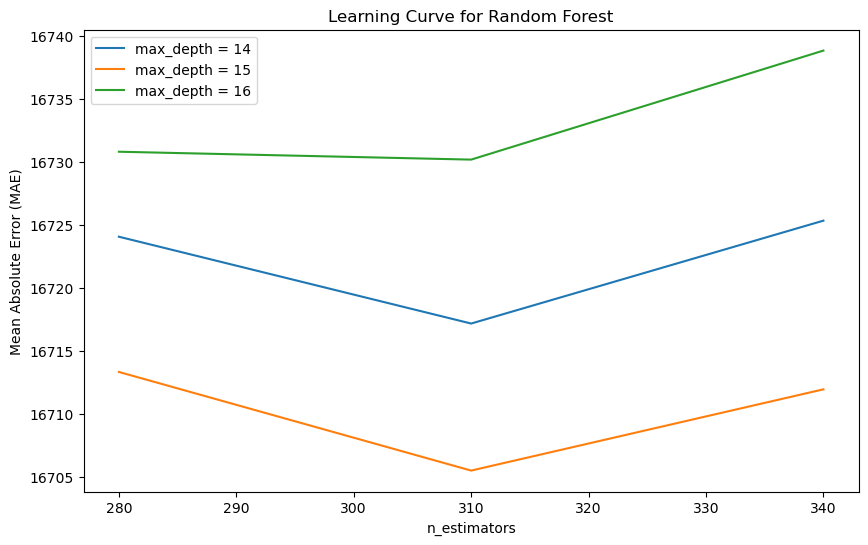

In [23]:


kf = KFold(n_splits=2, shuffle=True, random_state=0)

parameters = { 'n_estimators':[*range(280,341,30)]
                ,'criterion':["squared_error"]
                ,"max_depth":[14,15,16]
                ,'min_samples_leaf':[1]
                ,'min_samples_split':[4]
                }

rfr = RandomForestRegressor(random_state=0)
GS = GridSearchCV(rfr, parameters, cv=kf, scoring="neg_mean_absolute_error")
GS.fit(Xtrain_tree, Ytrain_lr)

# Extract results
results = GS.cv_results_
n_estimators_values = parameters['n_estimators']
max_depth_values = parameters['max_depth']
mean_mae = -results['mean_test_score']

# Reshape mean_mae to a 2D array for plotting
mean_mae = mean_mae.reshape(len(max_depth_values), len(n_estimators_values))

# Plot the learning curves
plt.figure(figsize=(10, 6))
for i, max_depth in enumerate(max_depth_values):
    plt.plot(n_estimators_values, mean_mae[i], label=f'max_depth = {max_depth}')
plt.xlabel('n_estimators')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Learning Curve for Random Forest')
plt.legend()
plt.show()


In [19]:
results

{'mean_fit_time': array([0.45898044, 1.20417261, 0.55720055, 1.44131935]),
 'std_fit_time': array([0.00101197, 0.02141976, 0.01994407, 0.02363217]),
 'mean_score_time': array([0.01001573, 0.02249753, 0.01001513, 0.02452135]),
 'std_score_time': array([2.00271606e-05, 4.56929207e-04, 2.06232071e-05, 4.79936600e-04]),
 'param_max_depth': masked_array(data=[5, 5, 6, 6],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[60, 160, 60, 160],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 5, 'n_estimators': 60},
  {'max_depth': 5, 'n_estimators': 160},
  {'max_depth': 6, 'n_estimators': 60},
  {'max_depth': 6, 'n_estimators': 160}],
 'split0_test_score': array([-18622.85456017, -18708.80588837, -17735.47572996, -17821.29352375]),
 'split1_test_score': array([-19531.8366758 , -19598.34191391, -18595.92182655, -18605.85969937

In [46]:
kf = KFold(n_splits=2, shuffle=True, random_state=0)

parameters = { 'n_estimators':[*range(260,341,20)]
                ,'criterion':["squared_error"]
                ,"max_depth":[14,15,16]
                ,'min_samples_leaf':[1]
                ,'min_samples_split':[4]
                }

rfr = RandomForestRegressor(random_state=0)
GS_mae = GridSearchCV(rfr, parameters, cv=kf, scoring="neg_mean_absolute_error")
GS_mae.fit(Xtrain_tree, Ytrain_lr)
GS_mse = GridSearchCV(rfr, parameters, cv=kf, scoring="neg_mean_squared_error")
GS_mse.fit(Xtrain_tree, Ytrain_lr)
GS_r2 = GridSearchCV(rfr, parameters, cv=kf, scoring="r2")
GS_r2.fit(Xtrain_tree, Ytrain_lr)

# Plot the learning curves
# plt.figure(figsize=(10, 6))
# for i, max_depth in enumerate(max_depth_values):
#     plt.plot(n_estimators_values, mean_mae[i], label=f'max_depth = {max_depth}')
# plt.xlabel('n_estimators')
# plt.ylabel('Mean Absolute Error (MAE)')
# plt.title('Learning Curve for Random Forest')
# plt.legend()
# plt.show()


GridSearchCV(cv=KFold(n_splits=2, random_state=0, shuffle=True),
             estimator=RandomForestRegressor(random_state=0),
             param_grid={'criterion': ['squared_error'],
                         'max_depth': [14, 15, 16], 'min_samples_leaf': [1],
                         'min_samples_split': [4],
                         'n_estimators': [260, 280, 300, 320, 340]},
             scoring='r2')

In [47]:
# Extract results
n_estimators_values = parameters['n_estimators']
max_depth_values = parameters['max_depth']

results_mae = GS_mae.cv_results_
mean_mae = -results_mae['mean_test_score']

results_mse = GS_mse.cv_results_
mean_rmse = np.sqrt(-results_mse['mean_test_score'])

results_r2 = GS_r2.cv_results_
mean_r2 = results_r2['mean_test_score']

# Reshape mean_mae to a 2D array for plotting
mean_mae = mean_mae.reshape(len(max_depth_values), len(n_estimators_values))
mean_rmse = mean_rmse.reshape(len(max_depth_values), len(n_estimators_values))
mean_r2 = mean_r2.reshape(len(max_depth_values), len(n_estimators_values))

In [48]:
print(mean_r2)

mean_r2
np.max(mean_r2)

[[0.89000239 0.89019184 0.89029125 0.89027941 0.89032783]
 [0.89014575 0.89030343 0.89026297 0.8902608  0.89032062]
 [0.89012091 0.89033    0.89028902 0.89020744 0.89032503]]


0.8903300036124265

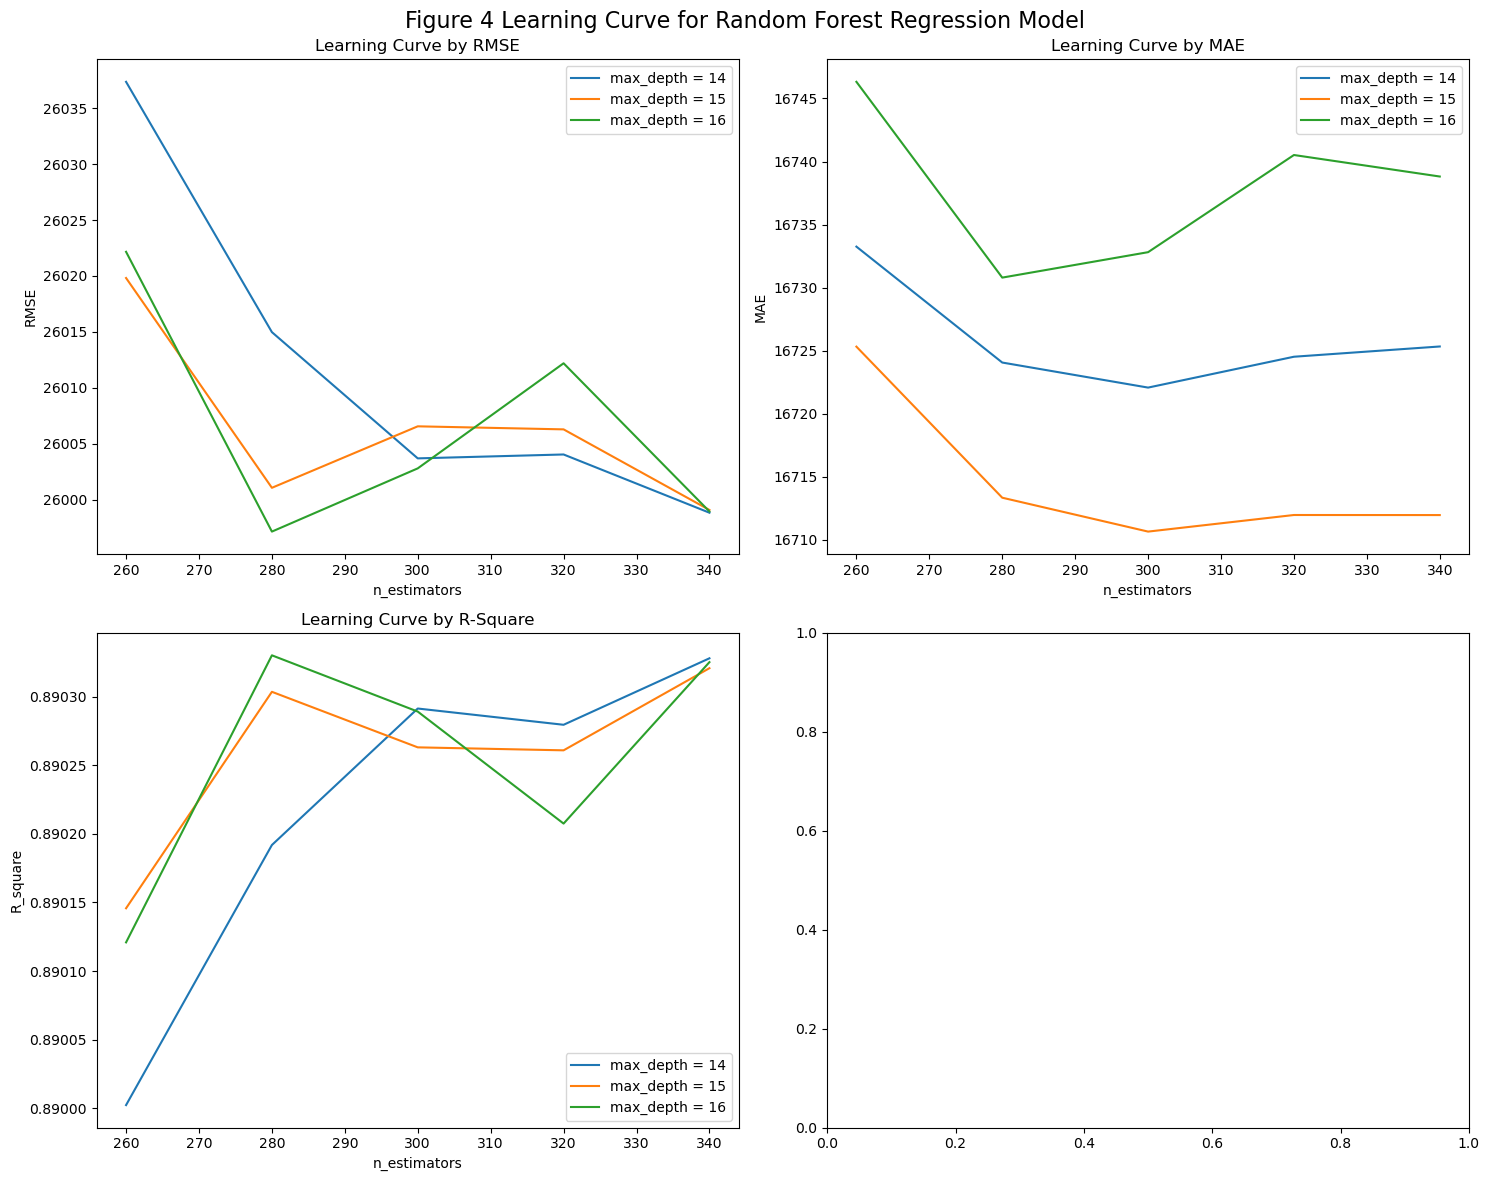

0.8903300036124265 26037.357533938484 16746.319981750858


In [49]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Figure 4 Learning Curve for Random Forest Regression Model", fontsize=16)
# Plot the R2 curve
for i, max_depth in enumerate(max_depth_values):
    axs[1,0].plot(n_estimators_values, mean_r2[i], label=f'max_depth = {max_depth}')
axs[1,0].set_title("Learning Curve by R-Square")
axs[1,0].legend()
axs[1,0].set_xlabel("n_estimators")
axs[1,0].set_ylabel("R_square")
# Plot the MAE curve
for i, max_depth in enumerate(max_depth_values):
    axs[0,1].plot(n_estimators_values, mean_mae[i], label=f'max_depth = {max_depth}')
axs[0,1].set_title("Learning Curve by MAE")
axs[0,1].legend()
axs[0,1].set_xlabel("n_estimators")
axs[0,1].set_ylabel("MAE")

for i, max_depth in enumerate(max_depth_values):
    axs[0,0].plot(n_estimators_values, mean_rmse[i], label=f'max_depth = {max_depth}')
axs[0,0].set_title("Learning Curve by RMSE")
axs[0,0].legend()
axs[0,0].set_xlabel("n_estimators")
axs[0,0].set_ylabel("RMSE")

# Find the maximum R2 value and annotate it on the R2 plot
# max_r2_alpha = n_estimators_values[np.argmax(mean_r2)]
# max_r2 = np.max(ridge_r2)
# axs[1,0].annotate(f"Max R2: {max_r2:.3f} (alpha={max_r2_alpha:.3f})", xy=(max_r2_alpha, max_r2))                

# # Find the minimum MAE value and annotate it on the MAE plot
# min_mae_alpha = alpharange[np.argmin(ridge_mae)]
# min_mae = np.min(ridge_mae)
# axs[0,1].annotate(f"Min MAE: {min_mae:.3f} (alpha={max_r2_alpha:.3f})", xy=(min_mae_alpha, min_mae))

# min_rmse_alpha = alpharange[np.argmin(ridge_rmse)]
# min_rmse = np.min(ridge_rmse)
# axs[0,0].annotate(f"Min RMSE: {min_rmse:.3f} (alpha={min_rmse_alpha:.3f})", xy=(min_rmse_alpha, min_rmse))

plt.tight_layout()
plt.show()

print(np.max(mean_r2),np.max(mean_rmse),np.max(mean_mae))

In [50]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

parameters = { 'n_estimators':[280]
                ,'criterion':["squared_error"]
                ,"max_depth":[16]
                ,'min_samples_leaf':[1]
                ,'min_samples_split':[4]
                }

rfr = RandomForestRegressor(random_state=0)
GS_mae = GridSearchCV(rfr, parameters, cv=kf, scoring="neg_mean_absolute_error")
GS_mae.fit(Xtrain_tree, Ytrain_lr)
GS_mse = GridSearchCV(rfr, parameters, cv=kf, scoring="neg_mean_squared_error")
GS_mse.fit(Xtrain_tree, Ytrain_lr)
GS_r2 = GridSearchCV(rfr, parameters, cv=kf, scoring="r2")
GS_r2.fit(Xtrain_tree, Ytrain_lr)

results_mae = GS_mae.cv_results_
mean_mae = -results_mae['mean_test_score']

results_mse = GS_mse.cv_results_
mean_rmse = np.sqrt(-results_mse['mean_test_score'])

results_r2 = GS_r2.cv_results_
mean_r2 = results_r2['mean_test_score']

print(np.max(mean_r2),np.max(mean_rmse),np.max(mean_mae))

0.8927521749758937 25578.55759710664 16280.450975107426


In [55]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

parameters = { 'n_estimators':[280]
                ,'criterion':["squared_error"]
                ,"max_depth":[15]
                ,'min_samples_leaf':[1]
                ,'min_samples_split':[4]
                }

rfr = RandomForestRegressor(random_state=0)
GS_mae = GridSearchCV(rfr, parameters, cv=kf, scoring="neg_mean_absolute_error")
GS_mae.fit(Xtest_tree, Ytest_lr)
GS_mse = GridSearchCV(rfr, parameters, cv=kf, scoring="neg_mean_squared_error")
GS_mse.fit(Xtest_tree, Ytest_lr)
GS_r2 = GridSearchCV(rfr, parameters, cv=kf, scoring="r2")
GS_r2.fit(Xtest_tree, Ytest_lr)

results_mae = GS_mae.cv_results_
mean_mae = -results_mae['mean_test_score']

results_mse = GS_mse.cv_results_
mean_rmse = np.sqrt(-results_mse['mean_test_score'])

results_r2 = GS_r2.cv_results_
mean_r2 = results_r2['mean_test_score']

print(np.max(mean_r2),np.max(mean_rmse),np.max(mean_mae))

0.860652469383458 31160.95913917534 18268.02997034356
